# Email Marketing Campaign

In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

# load dataset

In [3]:
# read `email_table.csv`
email_table = pd.read_csv('email_table.csv')
email_table.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [4]:
# basic information
email_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [5]:
# check missing values
email_table.isnull().sum()

email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
dtype: int64

In [6]:
# read email_opened_table.csv
email_opened = pd.read_csv('email_opened_table.csv')
email_opened.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [7]:
# basic information
email_opened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
email_id    10345 non-null int64
dtypes: int64(1)
memory usage: 80.9 KB


In [8]:
# read link_clicked_table.csv
link_table = pd.read_csv('link_clicked_table.csv')
link_table.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [9]:
# basic information
link_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
email_id    2119 non-null int64
dtypes: int64(1)
memory usage: 16.7 KB


In [10]:
# check uniqueness of email_id in three tables
print('email_table.csv:\t', len(email_table['email_id'].unique()))
print('email_opened_table.csv:\t', len(email_opened['email_id'].unique()))
print('link_clicked_table.csv:\t', len(link_table['email_id'].unique()))

email_table.csv:	 100000
email_opened_table.csv:	 10345
link_clicked_table.csv:	 2119


# Data Processing

In [11]:

# create new columns `opened` and `clicked`
email_opened['opened'] = 1
link_table['clicked'] = 1
data = pd.merge(left=email_table, right=email_opened, how='left', on='email_id')
data = pd.merge(left=data, right=link_table, how='left', on='email_id')
data = data.fillna(value=0)
data['opened'] = data['opened'].astype(int)
data['clicked'] = data['clicked'].astype(int)
data.head()


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


Question 1: What percentage of users opened the email and what percentage clicked on the link within the email?

In [12]:
print('{0:25s} {1:>8.4f}%'.format('Opened user percentage:', data['opened'].mean() * 100))
print('{0:25s} {1:>8.4f}%'.format('Clicked user percentage:', data['clicked'].mean() * 100))

Opened user percentage:    10.3450%
Clicked user percentage:    2.1190%


Question 2: The VP of marketing thinks that it is stupid to send emails in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email?



In [13]:
data.groupby('clicked')['email_id'].count() / len(data)

clicked
0    0.97881
1    0.02119
Name: email_id, dtype: float64

Clearly, the data is highly imbalanced:

$2.12\%$ of all the email is clicked.
$97.88\%$ of all the email is not clicked.
The imbalance of the data is a major challange for similar problems.

### Visualization of email_text

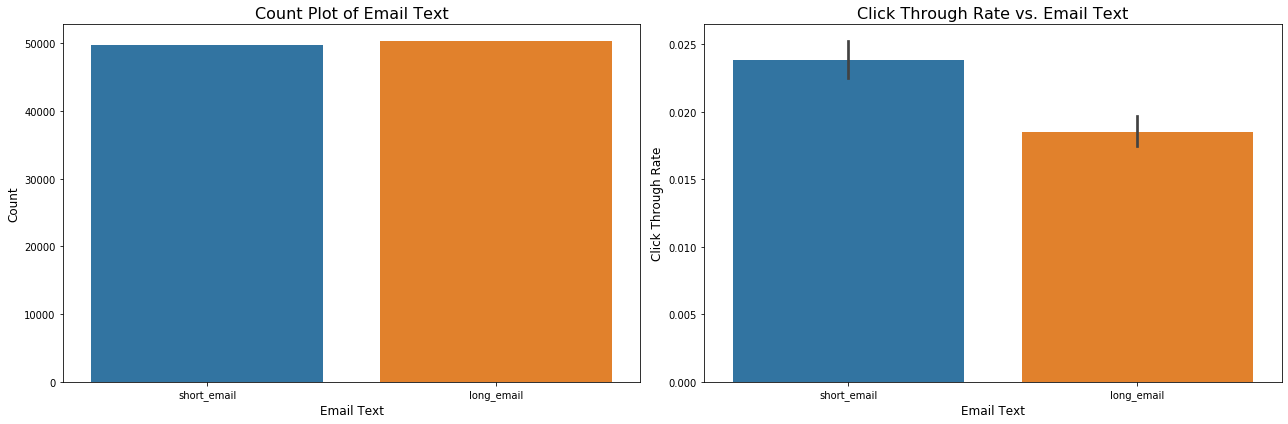

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_text', data=data, ax=ax[0])
ax[0].set_xlabel('Email Text', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Text', fontsize=16)

sns.barplot(x='email_text', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Text', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of email_version

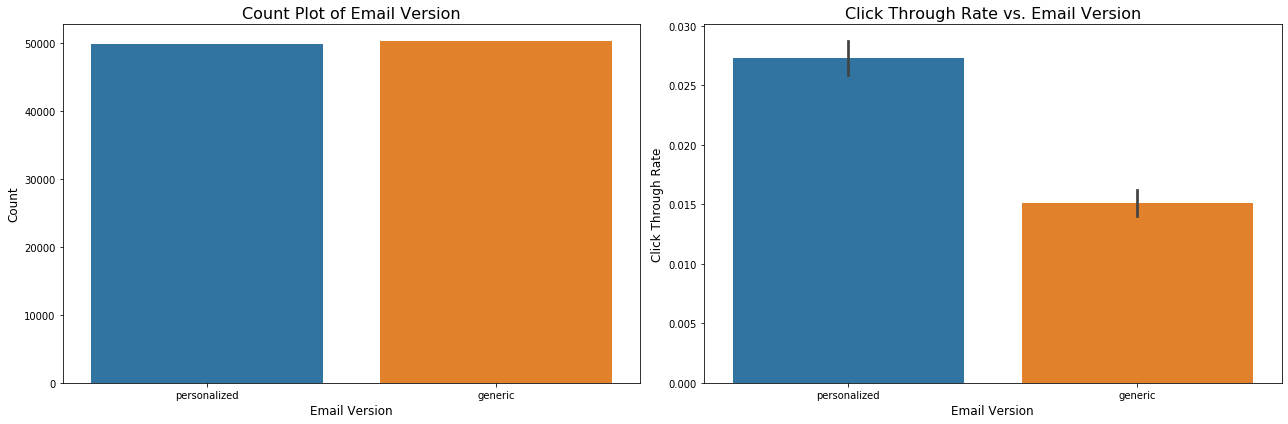

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_version', data=data, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)

sns.barplot(x='email_version', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of hour

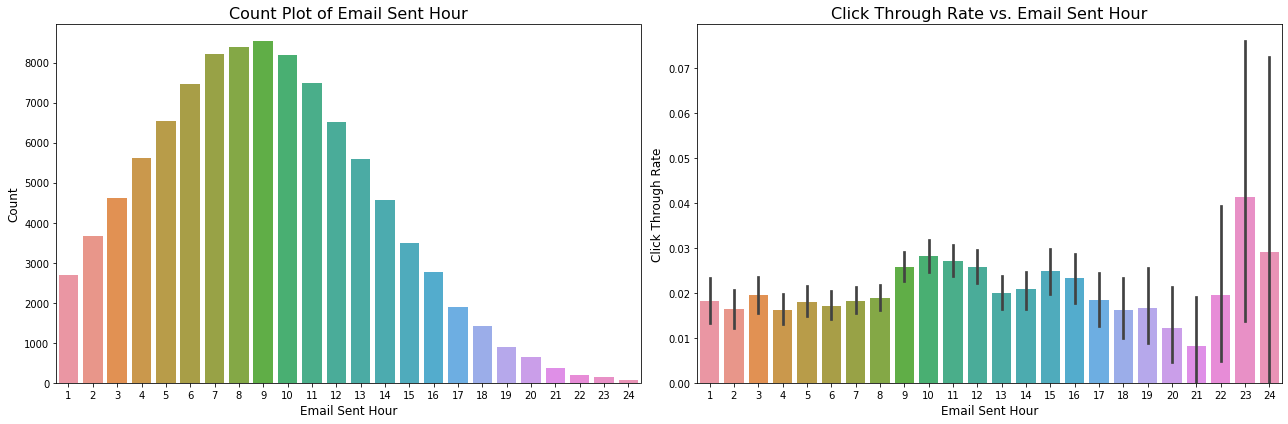

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)

sns.barplot(x='hour', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()


### Visualization of weekday

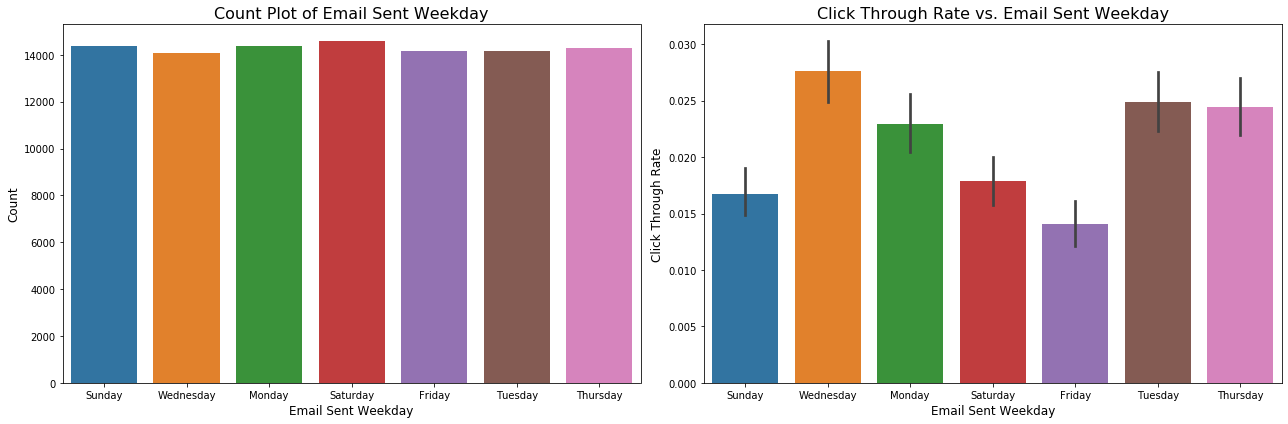

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='weekday', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Weekday', fontsize=16)

sns.barplot(x='weekday', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Weekday', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of user_country

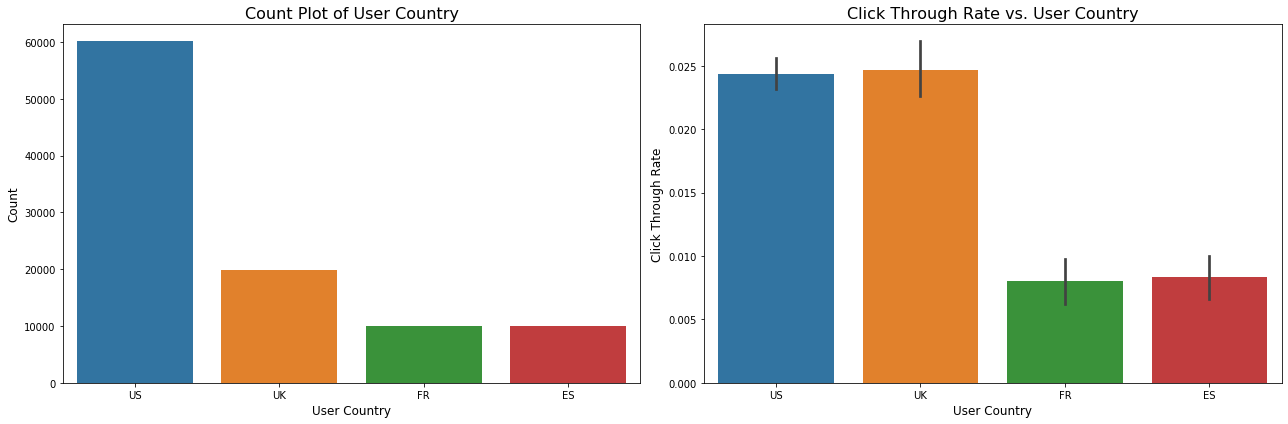

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_country', data=data, ax=ax[0])
ax[0].set_xlabel('User Country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Country', fontsize=16)

sns.barplot(x='user_country', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Country', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Country', fontsize=16)
plt.tight_layout()
plt.show()

### Visualization of user_past_purchases

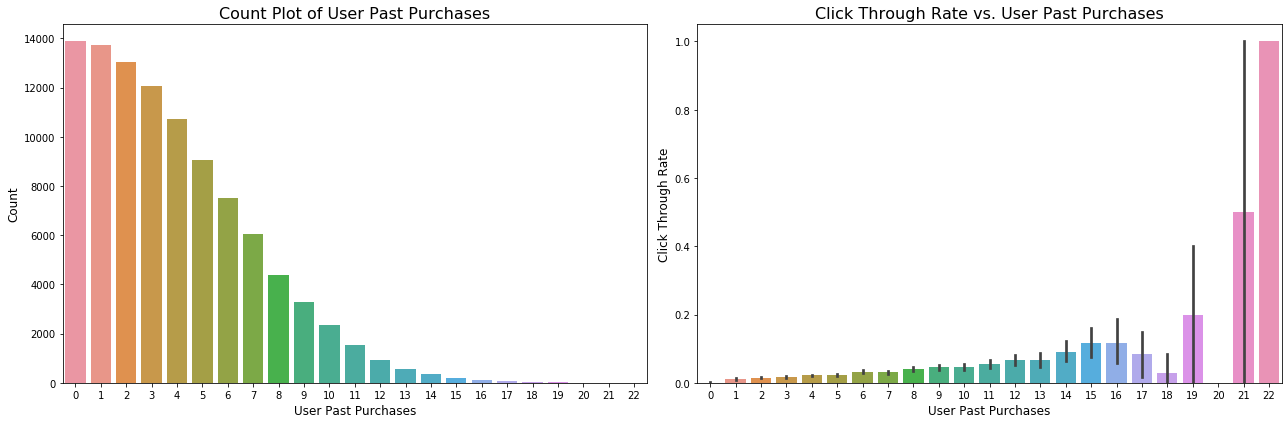

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_past_purchases', data=data, ax=ax[0])
ax[0].set_xlabel('User Past Purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Past Purchases', fontsize=16)

sns.barplot(x='user_past_purchases', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Past Purchases', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Past Purchases', fontsize=16)
plt.tight_layout()
plt.show()

Clearly, different features have different influence on the user click-through-rate. Now, let's try to build some machine learning models to try to predict the click probability. In this notebook, I only implement the Random Forest model with the default parameter settings without advanced optimization, such as grid search and so on.

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(4684)
data_dummy = pd.get_dummies(data)
train, test = train_test_split(data_dummy, test_size = 0.25)
feature = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = 'clicked'

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_features=6, oob_score=True)
rf.fit(train.drop('clicked', axis=1), train['clicked'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['clicked'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9755466666666667 
 OOB Confusion Matrix 
        0    1
0  73029  366
1   1468  137


In [30]:
# print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('clicked', axis=1),test['clicked']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['clicked'], rf.predict(test.drop('clicked', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.97792 
 Test Set Confusion Matrix 
        0   1
0  24399  87
1    465  49


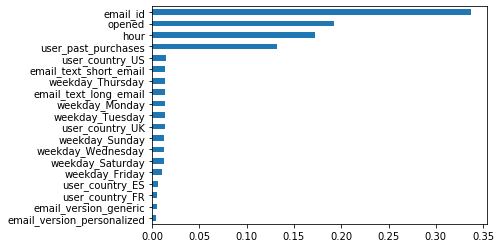

In [31]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('clicked', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

In [37]:
#We can double check that with a 0.5 cut-off we get the same results shown by rf output(since random forest internally uses 0.5)
#Predictions as probabilities
pred_prob=rf.predict_proba(test.drop('clicked', axis=1))[:,1]
#Predictions as actual classes
pred = rf.predict(test.drop('clicked', axis=1))
  
#Use 0.5 cutoff for probabilities. I.e. if larger > 0.5, predict 1, else predict 0. A short cut for this is using round function, which does exactly the same. If > 0.5, rounds to 1, else rounds to 0. Check if they are the same:
print(np.array_equal(pred_prob.round(), pred))

True


Text(0.5, 1.0, 'ROC')

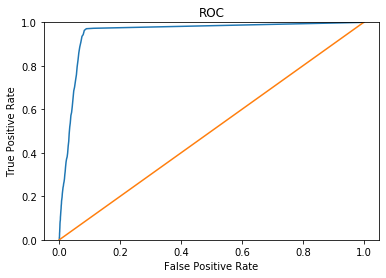

In [39]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
#Let's get false positive rate and true positive rate and plot them in the ROC
fpr, tpr, thresholds = roc_curve(test['clicked'],pred_prob)
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')

## Let’s check partial dependence plots for the 6 vars

In [40]:
feature = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
from pdpbox import pdp, info_plots

In [41]:
train.head()

,email_id,hour,user_past_purchases,opened,clicked,email_text_long_email,email_text_short_email,email_version_generic,email_version_personalized,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_ES,user_country_FR,user_country_UK,user_country_US
17371,926872,7,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0
87554,308048,7,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1
61857,159555,9,8,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
42874,50418,18,5,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
81598,447767,6,5,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1


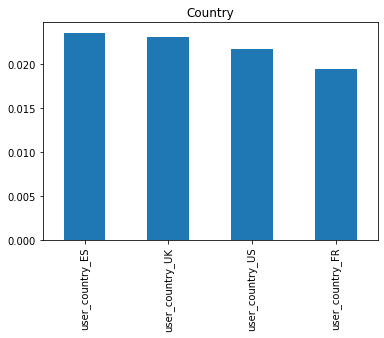

In [43]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['clicked'], axis=1),      
                          model_features=list(train.drop(['clicked'], axis=1)), 
                          feature=['user_country_FR', 'user_country_UK', 'user_country_US','user_country_ES'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()

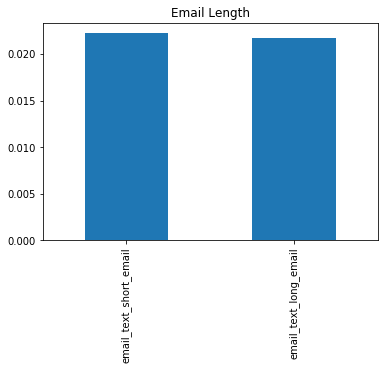

In [44]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['clicked'], axis=1),      
                          model_features=list(train.drop(['clicked'], axis=1)), 
                          feature=['email_text_long_email', 'email_text_short_email'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Email Length')
plt.show()

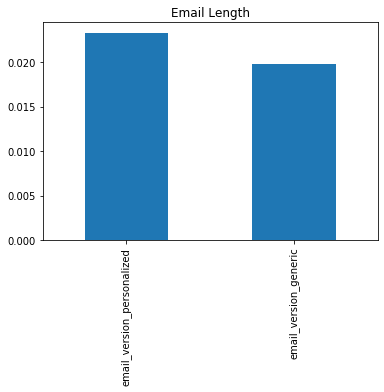

In [45]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['clicked'], axis=1),      
                          model_features=list(train.drop(['clicked'], axis=1)), 
                          feature=['email_version_generic', 'email_version_personalized'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Email Length')
plt.show()

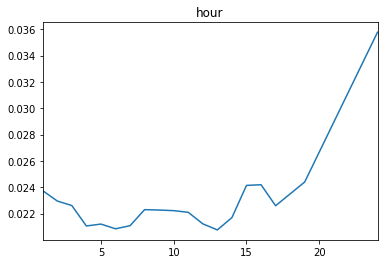

In [55]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                           dataset=train.drop(['clicked'], axis=1),      
                          model_features=list(train.drop(['clicked'], axis=1)),
                          feature='hour', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='hour')
plt.show()

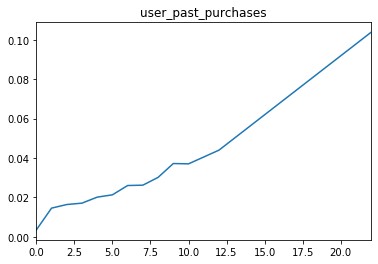

In [56]:
pdp_iso = pdp.pdp_isolate( model=rf, 
                           dataset=train.drop(['clicked'], axis=1),      
                          model_features=list(train.drop(['clicked'], axis=1)),
                          feature='user_past_purchases', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='user_past_purchases')
plt.show()

### Build a simple decision tree and check the 2 or 3 most important segments

In [57]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

In [58]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'

In [59]:
tree = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
tree.fit(train.drop(['clicked'], axis=1), train['clicked'])
export_graphviz(tree, out_file="tree_conversion.dot", feature_names=train.drop(['clicked'], axis=1).columns, proportion=True, rotate=True)
with open("tree_conversion.dot") as f:
    dot_graph = f.read()

In [60]:
s = Source.from_file("tree_conversion.dot")
s.view()

'tree_conversion.dot.pdf'

Question 3: By how much do you think your model would improve click through rate (defined as # of users who click on the link/total users who receive the email). How would you test that?

Based on the model built previously, the company can send email to selected users that are predicted to have higher probability to click the link.

To test it, we can conduct A/B test to see if the built model can actually help improve the click-through-rate.

1.Randomly assign users to two groups, Control group and Experiment group.

2.In Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.

3.In Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.

4.Preform a one-tail unpaired t-test to test whether Experiement group's population proportion is higher than Control group's population proportion.

Question 4: Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.
    ---See the partial dependence plot for details.